# DDPMs con el conjunto de imágenes de lesiones malignas de ISIC 2018, 2018 y 2020

En el presente notebook se muestra cómo entrenar un modelo de difusión DDPM para crear imágenes sintéticas 2D de lesiones malignas de piel (melanoma) usando el código del proyecto [MONAI][https://github.com/Project-MONAI/GenerativeModels]. El modelo DDPM se basa en el artículo de investigación de Ho et al. [1]. El conjunto de imágenes de entrenamiento está extraído de las imágenes clasificadas como lesiones malignas de los *datasets* proporcionados por ISIC en las ediciones de sus competiciones de los años 2018, 2019 y 2020, y que se han extraído de [Kaggle](https://www.kaggle.com/competitions/isic-2024-challenge/discussion/515356).

[1] - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239

## 1. Carga de librerías

In [1]:
import os
import random
import time
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision.transforms import transforms
import torch.optim.lr_scheduler as lr_scheduler

from tqdm import tqdm

from monai.config import print_config

from generative.metrics import FIDMetric, MultiScaleSSIMMetric, SSIMMetric

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.3.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /opt/anaconda3/envs/tfm/lib/python3.12/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.13.1
Pillow version: 10.3.0
Tensorboard version: 2.6.0
gdown version: 5.2.0
TorchVision version: 0.18.1
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN 

## 2. Parámetros importantes

In [2]:
IMAGE_SIZE = 64
PIC_CHANNELS = 3
PIC_DIMENSION = 2
BATCH_SIZE = 4
GRADIENT_ACCUMULATION = 8
EPOCHS = 200
LEARNING_RATE = 0.001
VAL_INTERVAL = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

## 3. Carga de las imágenes para el entrenamiento

De los conjuntos de imágenes ofrecidos por ISIC en sus competiciones de los años 2018, 2019 y 2020, cargamos todas las imágenes pertenecientes a la clase de lesiones malignas. Las reescalamos de tamaño y normalizamos al intervalo [0,1].

In [3]:
transformations = transforms.Compose([
    transforms.Resize(IMAGE_SIZE)
])

In [4]:
METADATA_FILE = '/Users/alzorrcarri/ISIC2018 Challenge/train-metadata.csv'
DATA_DIR = '/Users/alzorrcarri/ISIC2018 Challenge/train-image/image'

In [5]:
len_all = 0

In [6]:
metadata = pd.read_csv(METADATA_FILE, header=0)
dataset = []
for idx in range(len(metadata)):
    _, isic_id, patient_id, label = metadata.iloc[idx,]
    if label == 1.0:
        # Cargamos la imagen de la lesión si existe
        image = os.path.join(DATA_DIR, isic_id + '.jpg')
        if not os.path.exists(image):
            continue
        image = torch.tensor(plt.imread(image), dtype=torch.float32)
        # Hacemos el resto de transformaciones necesarias
        image = torch.transpose(image, 0, 2)
        image = transformations(image)/255.0
        dataset.append(image)

In [7]:
len(dataset)

662

In [8]:
len_all += len(metadata)

In [9]:
METADATA_FILE = '/Users/alzorrcarri/ISIC2019 Challenge/train-metadata.csv'
DATA_DIR = '/Users/alzorrcarri/ISIC2019 Challenge/train-image/image'

In [10]:
metadata = pd.read_csv(METADATA_FILE, header=0)
for idx in range(len(metadata)):
    _, isic_id, patient_id, label = metadata.iloc[idx]
    if label == 1.0:
        # Cargamos la imagen de la lesión si existe
        image = os.path.join(DATA_DIR, isic_id + '.jpg')
        if not os.path.exists(image):
            continue
        image = torch.tensor(plt.imread(image), dtype=torch.float32)
        # Hacemos el resto de transformaciones necesarias
        image = torch.transpose(image, 0, 2)
        image = transformations(image)/255.0
        dataset.append(image)

In [11]:
len(dataset)

5184

In [12]:
len_all += len(metadata)

In [13]:
METADATA_FILE = '/Users/alzorrcarri/ISIC2020 Challenge/train-metadata.csv'
DATA_DIR = '/Users/alzorrcarri/ISIC2020 Challenge/train-image/image'

In [14]:
metadata = pd.read_csv(METADATA_FILE, header=0)
for idx in range(len(metadata)):
    _, isic_id, patient_id, label = metadata.iloc[idx]
    if label == 1.0:
        # Cargamos la imagen de la lesión si existe
        image = os.path.join(DATA_DIR, isic_id + '.jpg')
        if not os.path.exists(image):
            continue
        image = torch.tensor(plt.imread(image), dtype=torch.float32)
        # Hacemos el resto de transformaciones necesarias
        image = torch.transpose(image, 0, 2)
        image = transformations(image)/255.0
        dataset.append(image)

In [15]:
len(dataset)

5768

En total, tenemos 5768 imágenes de lesiones malignas de piel para entrenar el modelo DDPM.

In [16]:
len_all += len(metadata)

In [17]:
len_all

67439

In [13]:
random.shuffle(dataset)

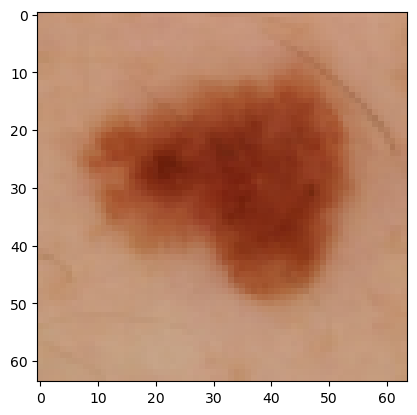

In [14]:
plt.imshow(dataset[0].permute(2, 1, 0))

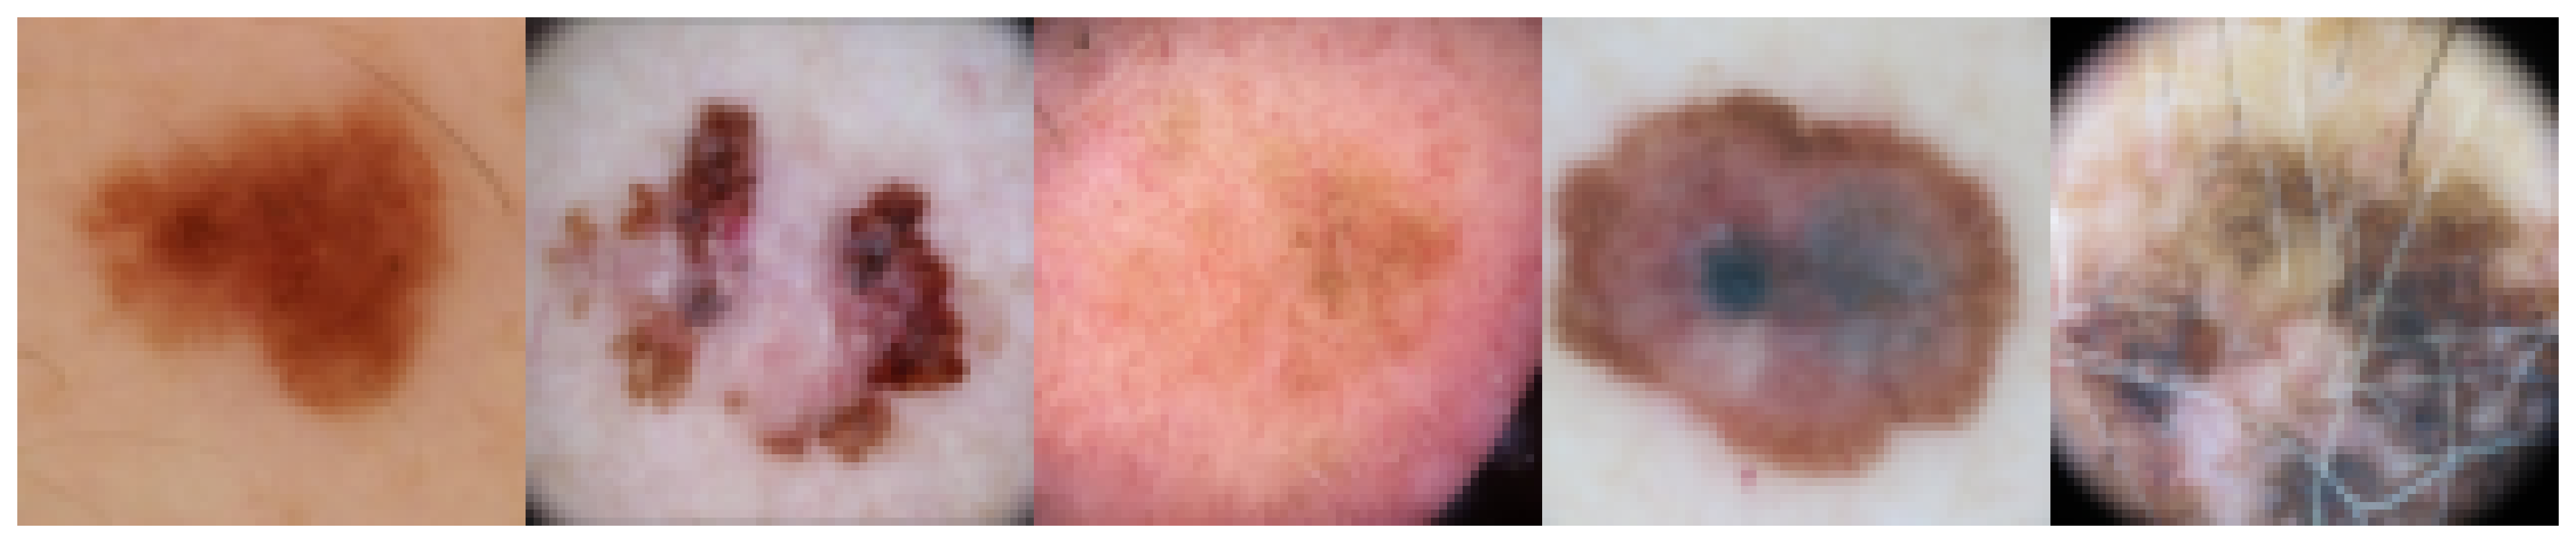

In [15]:
image_visualisation = torch.cat(
    [dataset[0].permute(2, 1, 0), dataset[1].permute(2, 1, 0), dataset[2].permute(2, 1, 0), dataset[3].permute(2, 1, 0),
      dataset[4].permute(2, 1, 0)], dim=1
)

plt.figure("preprocesed training images", (15, 6), dpi=300)
plt.imshow(image_visualisation)
plt.axis("off")
plt.tight_layout()
plt.show()

In [16]:
# Guardamos las imágenes de dataset en un directorio
os.makedirs("train_images", exist_ok=True)
for i, data in enumerate(dataset):
    image = data.cpu().permute(2, 1, 0).detach().numpy()
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    plt.imsave(f"train_images/{i}.jpg", image)

In [17]:
dataset = torch.stack(dataset)
train_loader = DataLoader(dataset[0:int(0.9*len(dataset))], batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)
val_loader = DataLoader(dataset[int(0.9*len(dataset)):], batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)

## 4. Entrenamiento de la red U-Net asociada al modelo DDPM

In [18]:
model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_channels=(64, 128, 256, 256),
    attention_levels=(False, False, True, True),
    num_res_blocks=1,
    num_head_channels=256
)
model.to(DEVICE)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

inferer = DiffusionInferer(scheduler)

/opt/anaconda3/envs/tfm/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/opt/anaconda3/envs/tfm/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 0:   0%|                               | 0/1298 [00:00<?, ?it/s]/opt/anaconda3/envs/tfm/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 1000/1000 [00:24<00:00, 40.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


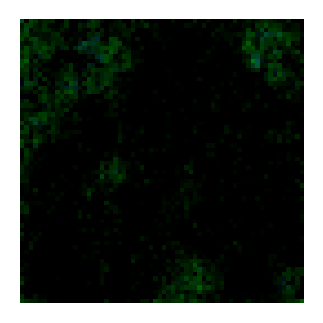

100%|██████████| 1000/1000 [00:24<00:00, 40.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


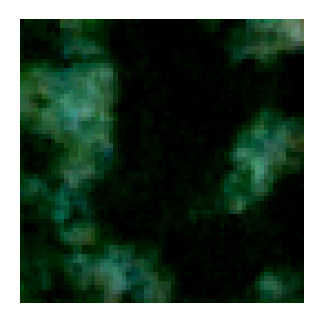

100%|██████████| 1000/1000 [00:24<00:00, 40.83it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


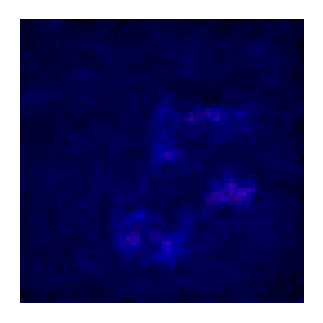

100%|██████████| 1000/1000 [00:24<00:00, 41.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


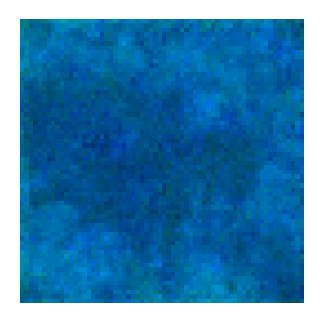

100%|██████████| 1000/1000 [00:24<00:00, 40.30it/s]


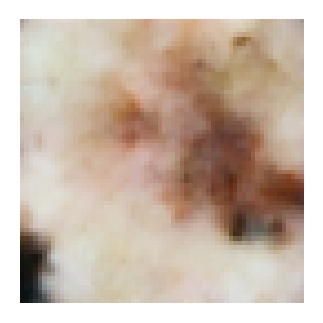

100%|██████████| 1000/1000 [00:24<00:00, 40.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


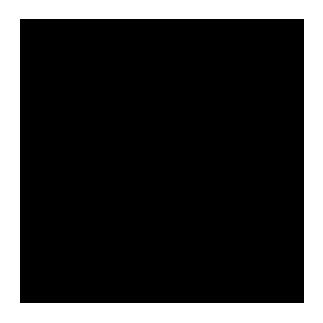

100%|██████████| 1000/1000 [00:24<00:00, 40.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


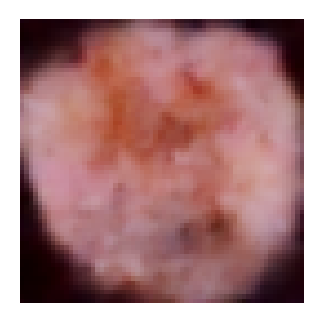

100%|██████████| 1000/1000 [00:23<00:00, 43.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


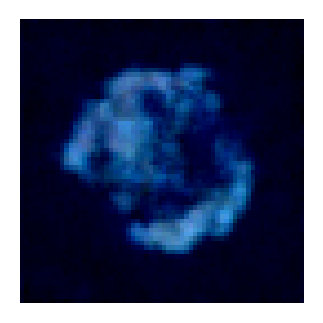

100%|██████████| 1000/1000 [00:23<00:00, 43.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


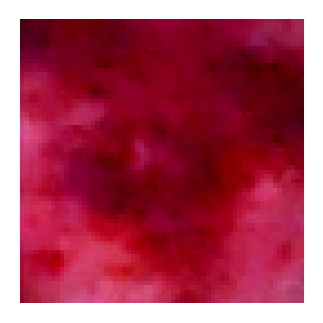

100%|██████████| 1000/1000 [00:23<00:00, 43.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


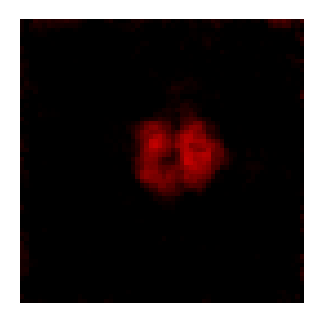

100%|██████████| 1000/1000 [00:24<00:00, 40.20it/s]


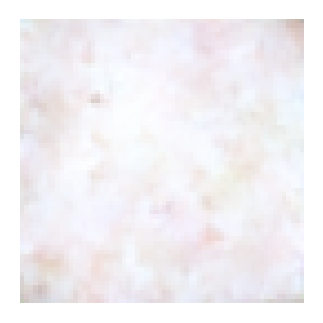

100%|██████████| 1000/1000 [00:23<00:00, 42.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


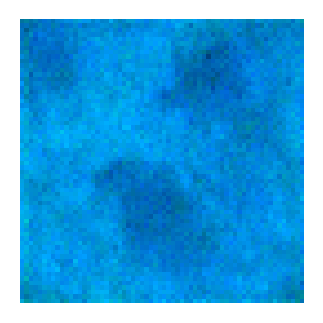

100%|██████████| 1000/1000 [00:23<00:00, 42.35it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


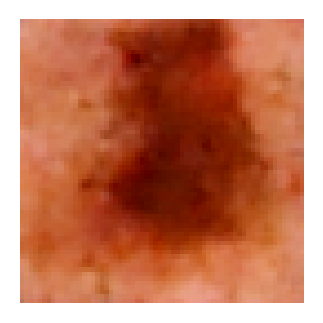

100%|██████████| 1000/1000 [00:23<00:00, 42.37it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


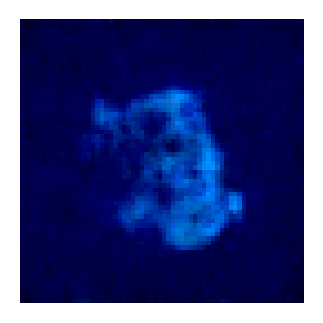

100%|██████████| 1000/1000 [00:23<00:00, 42.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


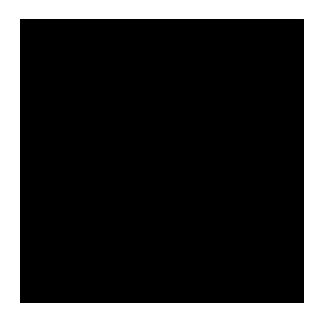

100%|██████████| 1000/1000 [00:23<00:00, 42.47it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


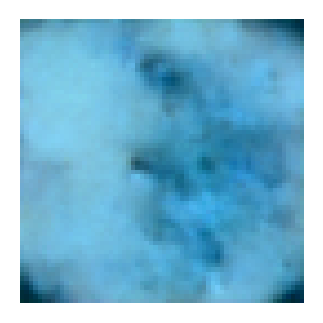

100%|██████████| 1000/1000 [00:23<00:00, 42.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


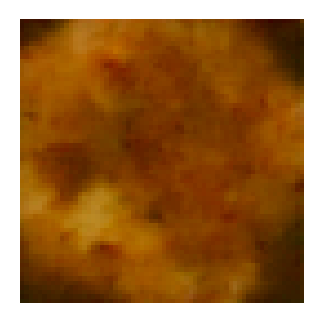

100%|██████████| 1000/1000 [00:24<00:00, 40.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


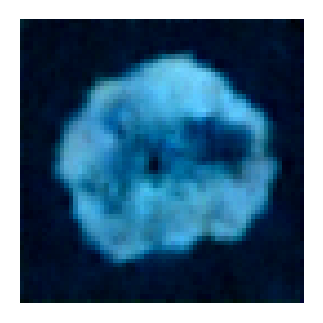

100%|██████████| 1000/1000 [00:23<00:00, 42.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


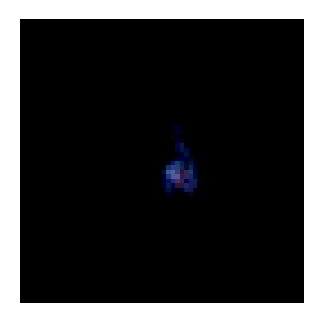

100%|██████████| 1000/1000 [00:23<00:00, 42.31it/s]


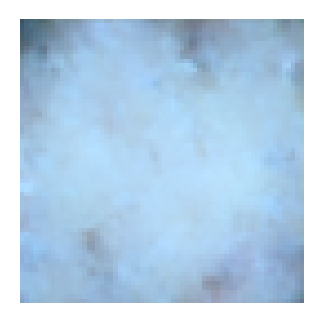

100%|██████████| 1000/1000 [00:23<00:00, 42.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


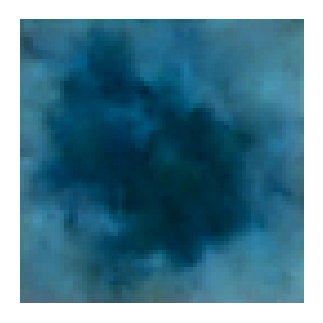

100%|██████████| 1000/1000 [00:23<00:00, 42.48it/s]


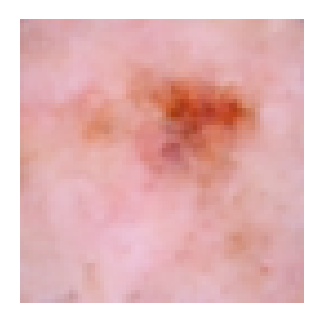

100%|██████████| 1000/1000 [00:23<00:00, 42.35it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


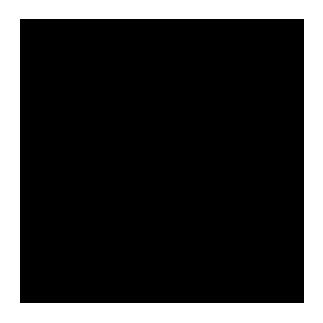

100%|██████████| 1000/1000 [00:23<00:00, 42.35it/s]


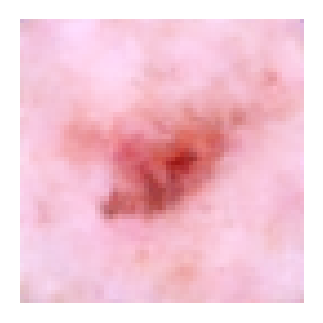

100%|██████████| 1000/1000 [00:24<00:00, 40.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


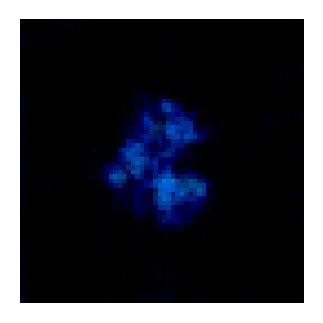

100%|██████████| 1000/1000 [00:24<00:00, 40.28it/s]


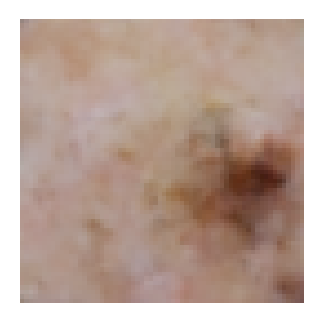

100%|██████████| 1000/1000 [00:24<00:00, 40.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


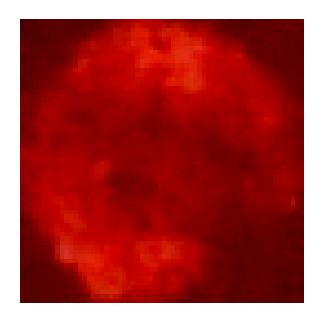

100%|██████████| 1000/1000 [00:23<00:00, 42.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


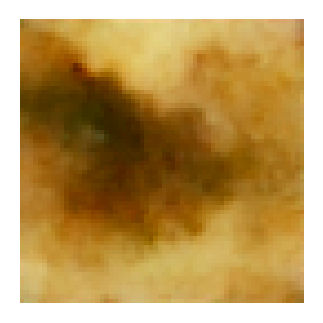

100%|██████████| 1000/1000 [00:24<00:00, 40.69it/s]


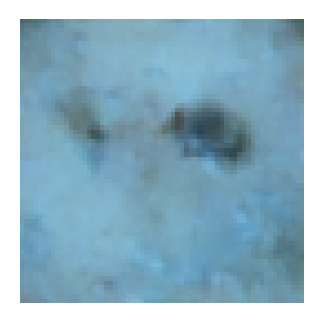

100%|██████████| 1000/1000 [00:24<00:00, 40.22it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


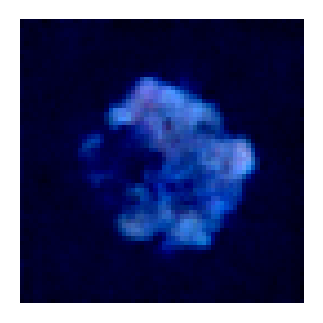

100%|██████████| 1000/1000 [00:24<00:00, 40.02it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


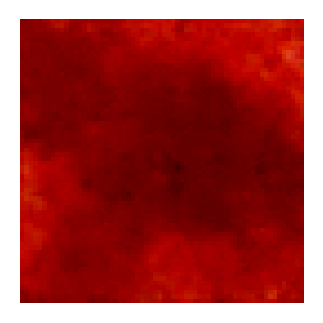

100%|██████████| 1000/1000 [00:23<00:00, 42.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


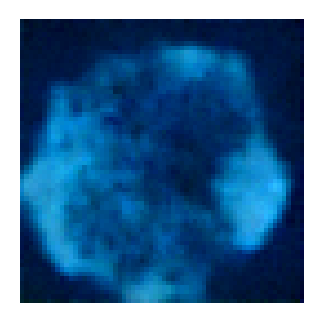

100%|██████████| 1000/1000 [00:24<00:00, 40.06it/s]


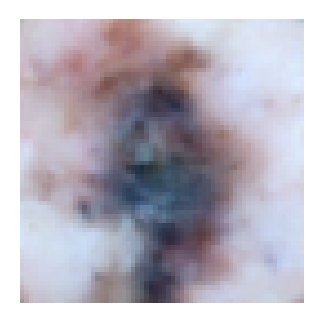

100%|██████████| 1000/1000 [00:25<00:00, 40.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


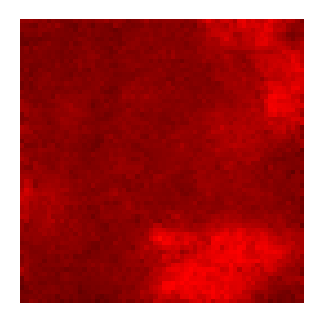

100%|██████████| 1000/1000 [00:24<00:00, 40.15it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


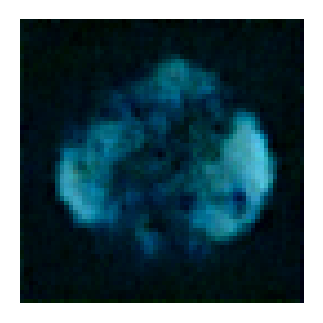

100%|██████████| 1000/1000 [00:23<00:00, 41.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


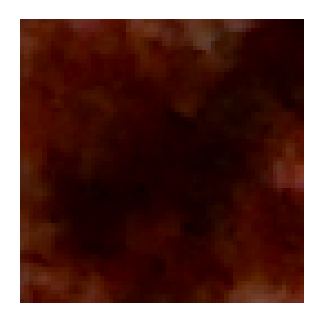

100%|██████████| 1000/1000 [00:23<00:00, 42.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


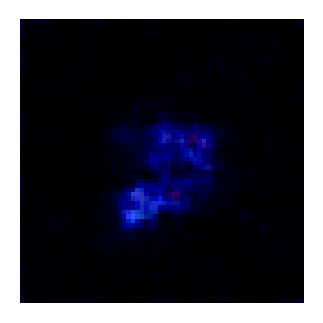

100%|██████████| 1000/1000 [00:23<00:00, 42.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


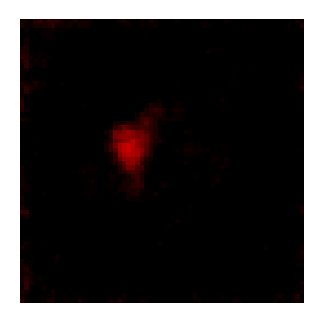

100%|██████████| 1000/1000 [00:23<00:00, 42.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


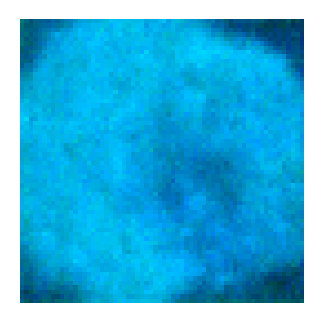

100%|██████████| 1000/1000 [00:24<00:00, 40.14it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


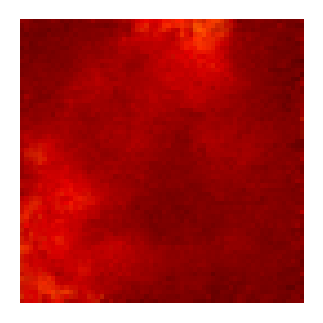

Entrenamiento completado, total time: 29162.28102517128.


In [19]:
val_interval = 5 # Intervalo de épocas para calcular la pérdida respecto al conjunto de validación
epoch_loss_list = [] # Para almacenar los valores de la función de pérdida en cada época
val_epoch_loss_list = []

# Definimos los distintos tipos de schedulers que podemos utilizar
lr_sch = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, threshold=0.0001, 
                                        threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-15, verbose=False)
lr_value_list = []

scaler = GradScaler()
total_start = time.time()

# Entrenamiento del modelo
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    mini_batch_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            noise = torch.randn_like(images).to(DEVICE)
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())
        scaler.scale(loss).backward()
        mini_batch_epoch_loss += loss.item()

        # Gradient accumulation
        if (step + 1) % GRADIENT_ACCUMULATION == 0:
            scaler.step(optimizer) # Actualizamos los pesos del modelo
            scaler.update()
            epoch_loss += mini_batch_epoch_loss/GRADIENT_ACCUMULATION
            mini_batch_epoch_loss = 0
        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    
    # Si quedan gradientes acumulados no usados al final del epoch
    if (step + 1) % GRADIENT_ACCUMULATION != 0:
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += mini_batch_epoch_loss/GRADIENT_ACCUMULATION
        mini_batch_epoch_loss = 0
    epoch_loss_list.append(epoch_loss / len(train_loader))
    lr_value_list.append(lr_sch.get_last_lr()[0])
    lr_sch.step(epoch_loss_list[-1]) # Actualizamos el learning rate

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        mini_batch_val_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch.to(DEVICE)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(DEVICE)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())
            mini_batch_val_loss += val_loss.item()
            if (step + 1) % GRADIENT_ACCUMULATION == 0:
                val_epoch_loss += mini_batch_val_loss
                mini_batch_val_loss = 0
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / len(val_loader))
    
        # Generamos una imagen durante el entrenamiento para observar la mejora de la calidad de las imágenes generadas
        noise = torch.randn((1, 3, IMAGE_SIZE, IMAGE_SIZE))
        noise = noise.to(DEVICE)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            syn_images = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)
        # Ploteamos una de las imágenes generadas
        plt.figure(figsize=(2, 2), dpi=200)
        plt.imshow(syn_images[0].cpu().permute(2, 1, 0))
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"Entrenamiento completado, total time: {total_time}.")

In [20]:
torch.save(model.state_dict(), "ddpm2d_hand_model.pt")

In [21]:
# Guardamos en un fichero csv los valores de la función de pérdida y del FID para cada epoch.
import csv

with open("ddpm2d_hand_model_numeric_results.csv", mode="w") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Train Loss", "Validation Loss", "Learning Rate"])
    i = 0
    for epoch in range(EPOCHS):
        if (epoch+1) % val_interval == 0:
            writer.writerow([epoch, epoch_loss_list[epoch], val_epoch_loss_list[i], lr_value_list[epoch]])
            i += 1
        else:
            writer.writerow([epoch, epoch_loss_list[epoch], "", lr_value_list[epoch]])